# Three Roads Problem: Introduction

This test system models bifurcation in a situation where there are two entities (can be nodes in a graph or people or something else) that need to coordinate.
One can imagine that these are two people that are in a store with very narrow aisles. Both of them are standing right in front of an obstacle separating the aisles, and want to avoid this obstacle by either swerving left or right. However, they don't want to bump into each other, so if one of them chooses the middle aisle (e.g., going left for the right person, going right for the left person), the other will not pick the same aisle.
The diagram below shows the inital input situation, and the three possible output situations, as well as the one forbidden option where the people collide into each other.

![title](Diagram.png)

We choose to model this as a very simple system with two input features and two output features. The input and output features are two numbers that indicate the horizontal position of both entities before and after deciding their path, respectively. For example, the input could be [1.0, 2.0]. Since the distance between these is $d=1.0$, then the possible coordinates in the 'aisles' are $1.0-d/2 = 0.5$ (left aisle), $1.0+d/2=2.0-d/2=1.5$ (middle aisle), $2.0+d/2=2.5$ (right aisle). The output coordinates for the two people can then be any of these combinations:
1) [0.5, 1.5]
2) [0.5, 2.5]
3) [1.5, 2.5]

In this test system, we have chosen to consider all these possibilities equally likely.

We model this as a graph with two nodes, with the initial position as a node attribute, and the final position as a predicted node attribute.



In [1]:
import pickle
import matplotlib.pyplot as plt
import torch

# The Dataset
Let's take a look at what the dataset actually looks like.

In [2]:
with open('../data/ThreeRoads_data.pkl', 'rb') as f:
    data = pickle.load(f)

for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(key, value.size())
    else:
        print(key, value)

data_tr = data['data_tr']
data_te = data['data_te']
x_m = data['x_m']
y_m = data['y_m']
x_std = data['x_std']
y_std = data['y_std']

data_tr torch.Size([1600, 2, 4])
data_te torch.Size([400, 2, 4])
x_m 0.2169664353132248
x_std 28.585941314697266
y_m 0.21696646511554718
y_std 38.53321838378906


The data is divided into training and testing data, and has already been normalized to have zero mean and unit standard deviation.

For both training and testing data, the shape is 

```[nr of data points, nr of features = 2, number of possible outputs + 1].```

Of the last dimension, the first entry corresponds to the input, and the remaining three correspond to the three possible outputs, meaning:
* ```data_tr[0, :, 0]``` is the input of the first data point in the training set, 
* ```and data_tr[0, :, 1:]``` are the corresponding possible outputs.

The three outputs have been shuffled, so they are random order. So if we want to test how to best train on a dataset where there is only one possible output given, then we take ```and data_tr[0, :, 1]``` to be the given target output.

In [3]:
print(data_tr[0, :, 0]*x_std + x_m)
print(data_tr[0, :, 1:]*y_std + y_m)

tensor([38.3375, 10.8332])
tensor([[52.0897, 52.0897, 24.5854],
        [24.5854, -2.9190, -2.9190]])


The plot below shows the initial values of node 1 and 2 in a scatter plot. It shows that the initial values are sampled uniformly from -50 to 50 and are not correlated.

Text(0, 0.5, 'Input value node 2')

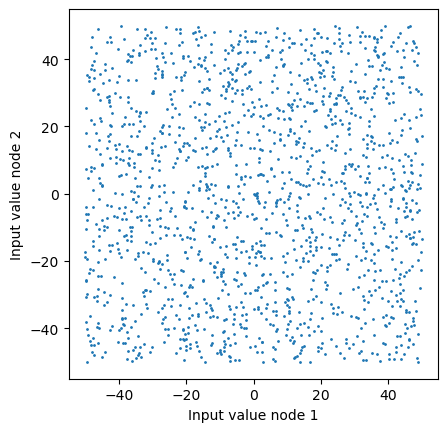

In [9]:
plt.scatter(data_tr[:, 0, 0].detach().numpy()*x_std + x_m,
            data_tr[:, 1, 0].detach().numpy()*x_std + x_m, s=1)
plt.gca().set_aspect('equal')
plt.xlabel('Input value node 1')
plt.ylabel('Input value node 2')

The plot below shows the initial value per node against the final value associated with that node. It shows knowing the initial value associated with a node is not enough to predict its final value.
This is because it depends on the other node as well.

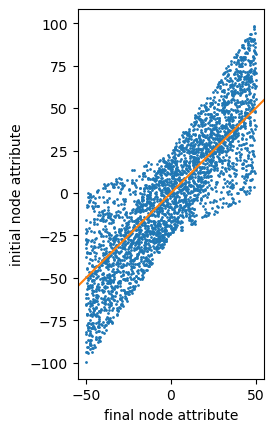

In [4]:
# visualize in vs out per node
plt.scatter(data_tr[:, 0, 0].detach().numpy()*x_std + x_m,
            data_tr[:, 0, 1].detach().numpy()*y_std + y_m, s=1, c='tab:blue')
plt.scatter(data_tr[:, 1, 0].detach().numpy()*x_std + x_m,
            data_tr[:, 1, 1].detach().numpy()*y_std + y_m, s=1, c='tab:blue')
plt.gca().set_aspect('equal')
plt.ylabel('initial node attribute')
plt.xlabel('final node attribute')
plt.axline([0,0], [1,1], c='tab:orange')

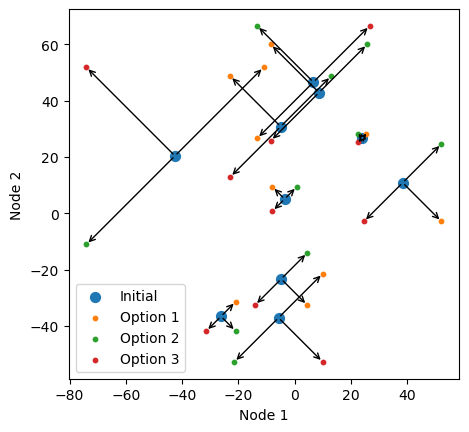

In [5]:
# Plot the bifurcations in the first 10 cases
fig, ax = plt.subplots()
fig.patch.set_facecolor("None")

for ind in range(10):
    pos1 = data_tr[ind, :, 0].numpy()*x_std + x_m  # input
    pos2a = data_tr[ind, :, 1].numpy()*y_std + y_m # three possible outputs
    pos2b = data_tr[ind, :, 2].numpy()*y_std + y_m
    pos2c = data_tr[ind, :, 3].numpy()*y_std + y_m

    ax.scatter(*pos1, c='tab:blue', s=50, label='Initial')
    ax.scatter(*pos2b, c='tab:orange', s=10, label='Option 1')
    ax.scatter(*pos2a, c='tab:green', s=10, label='Option 2')
    ax.scatter(*pos2c, c='tab:red', s=10, label='Option 3')

    ax.annotate('', xy=pos2a, xytext=pos1,
                arrowprops=dict(arrowstyle='->', facecolor='black'),
                )
    ax.annotate('', xy=pos2b, xytext=pos1,
                arrowprops=dict(arrowstyle='->', facecolor='black'),
                )
    ax.annotate('', xy=pos2c, xytext=pos1,
                arrowprops=dict(arrowstyle='->', facecolor='black'),
                )

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:4], labels[:4])
ax.set_xlabel('Node 1')
ax.set_ylabel('Node 2')
ax.set_aspect('equal')

plt.show()